In [183]:
using Random, Distributions
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [59]:
#Parameters that change between cells
cell_Jordi = Dict{String,Real}([
    ("x",0),
    ("x_neighbours",0),
    #Physical
    ("x1",0),
    ("x2",0),
    ("x3",0),
    ("v1",0),
    ("v2",0),
    ("v3",0),
    ("f1",0),
    ("f2",0),
    ("f3",0),
    #Shape
    ("r",0),
    ("m",0),
    #Division
    ("divTime",0)
]);

#Parameters that change at the community level
community_Jordi = Dict{String,Real}([
    ("n",0)
]);

In [60]:
#Parameters from the paper

α = 10
K = 0.9
n = 2.
m = 2.
fRange = 1.2
mInitial = 10^-6
rInitial = 5
b = 10^-6
K0 = 10^-4
fAdh = 1.5
μ = 2
τDiv = 10
σDiv = 0.5
x0 = 3.
σX = 0.01
Ncirc = 20
σNCirc = 0.1
fMin = 0.05
fMax = 0.95
fPre= 0.2
fEpi = 0.8
τCirc = 45.
στCirc = 0.02
rESC = 2.

2.0

In [168]:
#Dynamics
variablesMechanics = ["v1","v2","v3","x1","x2","x3"]
function mechanics(vars,t,cell,community)
    v1,v2,v3,x1,x2,x3 = vars
    dv1dt = (-b*v1+cell["f1"])/cell["m"]
    dv2dt = (-b*v2+cell["f2"])/cell["m"]
    dv3dt = (-b*v3+cell["f3"])/cell["m"]
    dx1dt = v1
    dx2dt = v2
    dx3dt = v3
    
    return [dv1dt,dv2dt,dv3dt,dx1dt,dx2dt,dx3dt]
end

variablesBiochemistry = ["x"]
function biochemistry(vars,t,cell,community)
    x, = vars
    dxdt = α*(1+x^n)^m/((1+x^n)^m+(cell["x_neighbours"]^n/K)^(2*m))-x
    return [dxdt]
end

#Cell-cell neighbours definitions
function neighboursDiffusion(cell1,cell2,community)
    rij = cell1["r"]+cell2["r"]
    d = sqrt((cell1["x1"]-cell2["x1"])^2+(cell1["x2"]-cell2["x2"])^2+(cell1["x3"]-cell2["x3"])^2)
    if d < μ*rij
        return true
    else
        return false
    end
end
function neighboursForce(cell1,cell2,community)
    rij = cell1["r"]+cell2["r"]
    d = sqrt((cell1["x1"]-cell2["x1"])^2+(cell1["x2"]-cell2["x2"])^2+(cell1["x3"]-cell2["x3"])^2)
    if d < fRange*rij
        return true
    else
        return false
    end
end

#Cell-cell computations
parametersForce = ["f1","f2","f3"]
function force(cell1,cell2,nNeighbours,community,t)
    rij = cell1["r"]+cell2["r"]
    d = sqrt((cell1["x1"]-cell2["x1"])^2+(cell1["x2"]-cell2["x2"])^2+(cell1["x3"]-cell2["x3"])^2)
    return K0*(rij/d-1)*(μ*rij/d-1)/d.*[cell1["x1"]-cell2["x1"],cell1["x2"]-cell2["x2"],cell1["x3"]-cell2["x3"]]
end
parametersChemical = ["x_neighbours"]
function diffussion(cell1,cell2,nNeighbours,community,t)
    return cell2["x"]/nNeighbours
end

#Division condition
function divisionCondition(cell,t,community)
    return cell["divTime"] < t
end

#Division
divisionParameters = ["r","m","x1","x2","x3","divTime"]
function division(cellP,cellD1,cellD2,t)
    #Update radius
    cellD1["r"] = cellP["r"]/2^(1/3)
    cellD2["r"] = cellP["r"]/2^(1/3)
    #Update mass
    cellD1["m"] = cellP["m"]/2
    cellD2["m"] = cellP["m"]/2
    #Update pos
    axis = rand(Normal(0,1),3)
    axis = axis/sum(axis)
    cellD1["x1"] = cellP["x1"]+axis[1]*cellP["r"]/2
    cellD1["x2"] = cellP["x2"]+axis[2]*cellP["r"]/2
    cellD1["x3"] = cellP["x3"]+axis[3]*cellP["r"]/2
    cellD2["x1"] = cellP["x1"]-axis[1]*cellP["r"]/2
    cellD2["x2"] = cellP["x2"]-axis[2]*cellP["r"]/2
    cellD2["x3"] = cellP["x3"]-axis[3]*cellP["r"]/2
    #Update concentration
    asymmetry = rand(Uniform(-σX,σX))
    cellD1["x"] = cellP["x"]+asymmetry
    cellD2["x"] = cellP["x"]-asymmetry
    #Update division time
    divTime = rand(Uniform(t+τDiv*(1-σDiv),t+τDiv*(1+σDiv)),2)
    cellD1["divTime"] = cellP["divTime"]+divTime[1]
    cellD2["divTime"] = cellP["divTime"]+divTime[2]
end

division (generic function with 1 method)

In [169]:
#Integrators
function rungeKutta4(variables,f::Function,t,dt,cell,community)
    k0 = [cell[i] for i in variables]
    k1 = f(k0,t,cell,community)
    k2 = f(k0+0.5*k1*dt,t+0.5*dt,cell,community)
    k3 = f(k0+0.5*k2*dt,t+0.5*dt,cell,community)
    k4 = f(k0+k3*dt,t+dt,cell,community)
    return k0+(k1+2*k2+2*k3+k4)*dt/6
end

rungeKutta4 (generic function with 1 method)

In [170]:
community = [copy(cell_Jordi) for i in 1:100];
communityParameters = copy(community_Jordi)

Dict{String,Real} with 1 entry:
  "n" => 0

In [171]:
community[1]["x"] = 1
community[1]["x_neighbours"] = 1
community[1]["x1"] = 0
community[1]["x2"] = 0
community[1]["x3"] = 0
community[1]["v1"] = 0
community[1]["v2"] = 0
community[1]["v3"] = 0
community[1]["f1"] = 0
community[1]["f2"] = 0
community[1]["f3"] = 0
community[1]["r"] = rInitial
community[1]["m"] = mInitial
community[1]["divTime"] = rand(Uniform(τDiv*(1-σDiv),τDiv*(1+σDiv)))

communityParameters["n"] = 1

1

In [172]:
function neighbours!(community,communityParameters,nnBioN, nnBio, nnForceN, nnForce)

    for i in 1:communityParameters["n"]
        #Add themselves
        nnBioN[i] = 0
        if neighboursDiffusion(community[i],community[i],communityParameters)
            nnBioN[i] += 1
            nnBio[i,nnBioN[i]] = i
        end
        nnForceN[i] = 0
        if neighboursForce(community[i],community[i],communityParameters)
            nnForceN[i] += 1
            nnForce[i,nnForceN[i]] = i
        end
        #Go over the other possible neighbours
        for j in (i+1):communityParameters["n"]
            if neighboursDiffusion(community[i],community[j],communityParameters)
                nnBioN[i] += 1
                nnBio[i,nnBioN[i]] = j
            end
            if neighboursForce(community[i],community[j],communityParameters)
                nnForceN[i] += 1
                nnForce[i,nnForceN[i]] = j
            end
        end
    end
    
end

function evolve(community,communityParameters,dt,T)
    t = 0
    communityAux = copy(community)
    #Make neighbours
    nnBioN = zeros(Int,length(community))
    nnBio = zeros(Real,length(community),10)
    nnForceN = zeros(Int,length(community))
    nnForce = zeros(Real,length(community),10)
    dividing = false
    dividingList = []
    
    #Compute neighbours for the first time
    neighbours!(community,communityParameters,nnBioN, nnBio, nnForceN, nnForce)
        
    while t < T
        #Evolution of dynamical systems
        for i in 1:communityParameters["n"]
            aux = rungeKutta4(variablesBiochemistry,biochemistry,t,dt,community[i],communityParameters)
            for j in 1:length(variablesBiochemistry)
                community[i][variablesBiochemistry[j]] = aux[j]
            end
        end
        for i in 1:communityParameters["n"]
            aux = rungeKutta4(variablesMechanics,mechanics,t,dt,community[i],communityParameters)
            for j in 1:length(variablesMechanics)
                community[i][variablesMechanics[j]] = aux[j]
            end
        end
        #Check division
        dividingList = []
        for i in 1:communityParameters["n"]
            if divisionCondition(community[i],t,communityParameters)
                dividing = true
                append!(dividingList,i)
            end
        end
        #Compute division
        if dividing
            n = communityParameters["n"]
            for i in 1:length(dividingList)
                division(community[i], community[n], community[n+1], t)
                for key in keys(community[i])
                    if !(key in divisionParameters)
                        community[n][key] = community[i][key]
                        community[i][key] = community[i][key]
                    else
                        community[i][key] = community[n][key]                        
                    end
                end
                n += 1
            end
            communityParameters["n"] = n
            dividing = false
        end
        #Compute neighbours
        neighbours!(community,communityParameters,nnBioN, nnBio, nnForceN, nnForce)
        
        #Compute cell-cell measures
        for i in 1:communityParameters["n"]
            #Clean para
            for key in parametersChemical
                communityAux[i][key] = 0
            end
            #Compute
            for j in nnBio
                aux = diffussion(community[i],community[i],nnBioN,communityParameters,t)
                for k in 1:length(parametersChemical)
                    communityAux[i][parametersChemical[k]] += aux[k] 
                end
            end

            #Clean
            for key in parametersForce
                communityAux[i][key] = 0
            end
            #Compute
            for j in nnForce
                aux = diffussion(community[i],community[i],nnForceN,communityParameters,t)
                for k in 1:length(parametersForce)
                    communityAux[i][parametersForce[k]] += aux[k] 
                end
            end
        end
        for i in 1:communityParameters["n"]
            for key in parametersChemical
                community[i][key] = communityAux[i][key]
            end
            for key in parametersForce
                community[i][key] = communityAux[i][key]
            end
        end
        t += dt        
    end
end

evolve (generic function with 1 method)

In [173]:
evolve(community, communityParameters, 0.1, 100);

In [177]:
[community[i]["x3"] for i in 1:5]

5-element Array{Float64,1}:
 1.677227824676399e8
 1.6772277934070176e8
 1.677227824676399e8
 1.6772277934070176e8
 1.7526193736210582e8

In [194]:
rij = 6
l = []
for d in 4:0.1:15
    append!(l,K0*(rij/d-1)*(μ*rij/d-1))
end

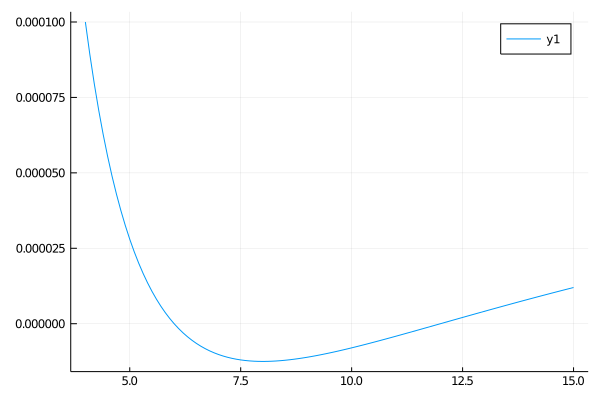

In [195]:
plot(4:0.1:15,l)

In [219]:
function sf1(x)
    return x
end

function sf2(x)
    return 2*x
end

text = [sf1,sf2]
arr = "["
for i in text
    arr = string(arr,i,"(x),")
end
arr = string(arr[1:end-1],"]")
symb = Meta.parse(arr)

expr = 
quote
    function f(x)
        return $symb
    end
end

eval(expr)
f(3)

2-element Array{Int64,1}:
 3
 6

In [244]:
function sf1(x,y)
    return println("Print ", x)
end

function sf2(x,y)
    return println("Print ",2*x)
end

#Execute different functions
vars = [:x,:y]
symb = [:(sf1($(vars...))),:(sf2($(vars...)))]

expr = 
quote
    function f(x,y)
            $(symb[1:2]...)
        return
    end
end

eval(expr)
f(3,4)

Print 3
Print 6


In [231]:
a.head

:call

In [21]:
for i in a.args
    println(typeof(i))
    if typeof(i) == Expr
        println(i.head)
    end
end

Symbol
Int64
Expr
call


In [249]:
length([Nothing,2,3])

3